In [1]:
import json
import os.path as osp
import os
import numpy as np
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.utils import to_undirected
from torch_cluster import radius_graph, knn_graph
from torch_geometric.datasets import MNISTSuperpixels
import torch_geometric.transforms as T
from torch_geometric.data import DataLoader
from tqdm import tqdm
import argparse
import utils
import model.net as net
import model.data_loader as data_loader
from evaluate import evaluate
import warnings
warnings.simplefilter('ignore')
from time import strftime, gmtime

### Change from DeepMETv2

1. Change x_cont, x_cat, etaphi in train() in accordance with the change of training inputs 
2. Add n_features_cont, n_features_cat to keep track of these numbers here and there, i.e. when building a model these numbers go into arguments
3. Remove the resolution-MET plotting part in evaluate, as L1 doesn't have bunch of METs that DeepMETv2 has access to
4. Add input scaling to [0,1] (norm)
5. Add weight_decay to the optimizer, remove patience from the scheduler 

In [3]:
doRestore = False
restore_file = 'best'      # Optional, name of the file in --model_dir containing weights to reload before training

pre_fix = '/export/home/phys/kyungmip/L1DeepMETv2/'

data_dir = pre_fix + 'data_ttbar/'        # name of the data folder
ckpts = pre_fix + 'ckpts_sep21/'       # name of the ckpts folder

In [4]:
epochs = 20
batch_size = 32
lr = 1e-4
weight_decay = 0.001

In [5]:
n_features_cont = 6
n_features_cat = 2

In [6]:
def train(model, device, optimizer, scheduler, loss_fn, dataloader, epoch):
    model.train()
    loss_avg_arr = []
    true_px_arr, true_py_arr, METx_arr, METy_arr = [], [], [], []
    loss_avg = utils.RunningAverage()

    #with tqdm(total=len(dataloader)) as t:
    #    for data in dataloader:
    #        print(data.x[0])
    #        break

    with tqdm(total=len(dataloader)) as t:
        for data in dataloader:
            optimizer.zero_grad()
            data = data.to(device)

            x_cont = data.x[:,:n_features_cont]       # include puppi
            #x_cont = data.x[:,:(n_features_cont-1)]  # remove puppi
            x_cat = data.x[:,n_features_cont:].long()

            #phi = torch.atan2(data.x[:,2], data.x[:,1])   # atan2(py, px)
            etaphi = torch.cat([data.x[:,3][:,None], data.x[:,4][:,None]], dim=1)

            # NB: there is a problem right now for comparing hits at the +/- pi boundary
            edge_index = radius_graph(etaphi, r=deltaR, batch=data.batch, loop=True, max_num_neighbors=255)
            result = model(x_cont, x_cat, edge_index, data.batch)
            loss, true_px, true_py, METx, METy = loss_fn(result, data.x, data.y, data.batch)
            loss.backward()
            optimizer.step()
            # update the average loss
            loss_avg_arr.append(loss.item())
            true_px_arr.append(true_px.cpu().numpy())
            true_py_arr.append(true_py.cpu().numpy())
            METx_arr.append(METx.detach().cpu().numpy())
            METy_arr.append(METy.detach().cpu().numpy())
            
            loss_avg.update(loss.item())
            t.set_postfix(loss='{:05.3f}'.format(loss_avg()))
            t.update()
    
    scheduler.step(np.mean(loss_avg_arr))
    print('Training epoch: {:02d}, MSE: {:.4f}'.format(epoch, np.mean(loss_avg_arr)))

    model_dir = osp.join(ckpts)
    os.system('mkdir -p {}/MODELS'.format(model_dir))

    #torch.save(model, '{}/MODELS/model_epoch{}.pt'.format(model_dir, epoch))

    return np.mean(loss_avg_arr), true_px_arr, true_py_arr, METx_arr, METy_arr

In [7]:
os.environ['PWD']

'/export/home/phys/kyungmip'

In [8]:
dataloaders = data_loader.fetch_dataloader(data_dir = data_dir, batch_size=int(batch_size), validation_split=.2)

train_dl = dataloaders['train']
test_dl = dataloaders['test']

print('Training dataloader: {}, Test dataloader: {}'.format(len(train_dl), len(test_dl)))

Split: 167410
length of train/val data:  669644 167410
Training dataloader: 20927, Test dataloader: 5232


In [9]:
os.environ["CUDA_VISIBLE_DEVICES"] = str(2)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [10]:
# Input norm
norm = torch.tensor([1., 1., 1., 1., 1., 1.]).to(device)   # pt, px, py: match it to genMETx genMETx scale factor
#norm = torch.tensor([1./1000., 1./1000., 1./1000., 1., 1., 1.]).to(device)   # pt, px, py: match it to genMETx genMETx scale factor
#norm = torch.tensor([1./499.25, 1./491.312, 1./495.928, 1./5.035, 1./3.142, 1.]).to(device)   # Have inputs within [0,1]

# Model
model = net.Net(n_features_cont, n_features_cat, norm).to(device) #include puppi
#model = net.Net(n_features_cont-1, n_features_cat, norm).to(device) #remove puppi

# Optimizer and scheduler
optimizer = torch.optim.AdamW(model.parameters(),lr=float(lr), weight_decay=float(weight_decay))
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr = 1e-5, max_lr = 1e-4, cycle_momentum=False)
#scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr = 0.1)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, threshold=0.05)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=500, threshold=0.05)

In [11]:
first_epoch = 0
best_validation_loss = 10e7
    
deltaR = 0.4
deltaR_dz = 0.3

loss_fn = net.loss_fn_compare
metrics = net.metrics

model_dir = ckpts

os.system('mkdir -p {}'.format(model_dir))
loss_log = open(model_dir+'/loss.log', 'w')
loss_log.write('# loss log for training starting in '+strftime("%Y-%m-%d %H:%M:%S", gmtime()) + '\n')
loss_log.write('epoch, loss, val_loss\n')
loss_log.flush()

In [12]:
# reload weights from restore_file if specified
if doRestore:
    if restore_file is not None:
        restore_ckpt = osp.join(model_dir, restore_file + '.pth.tar')
        ckpt = utils.load_checkpoint(restore_ckpt, model, optimizer, scheduler)
        first_epoch = ckpt['epoch']
        print('Restarting training from epoch',first_epoch)
        with open(osp.join(model_dir, 'metrics_val_best.json')) as restore_metrics:
            best_validation_loss = json.load(restore_metrics)['loss']

In [ ]:
#for epoch in range(first_epoch+1,101):
for epoch in range(first_epoch+1, epochs):
    print('Current best loss:', best_validation_loss)
    if '_last_lr' in scheduler.state_dict():
        print('Learning rate:', scheduler.state_dict()['_last_lr'][0])

    # compute number of batches in one epoch (one full pass over the training set)
    train_loss, true_px_arr, true_py_arr, METx_arr, METy_arr = train(model, device, optimizer, scheduler, loss_fn, train_dl, epoch)

    #print(true_px_arr, true_py_arr, METx_arr, METy_arr)
    
    # Save weights
    utils.save_checkpoint({'epoch': epoch,
                            'state_dict': model.state_dict(),
                            'optim_dict': optimizer.state_dict(),
                            'sched_dict': scheduler.state_dict()},
                            is_best=False,
                            checkpoint=model_dir)

    m = torch.jit.script(model)
    torch.jit.save(m, f'{model_dir}/MODELS/scripted_model_epoch{epoch}.pt')
    #m.save("scriptmodule.pt")
    
    torch.save(model, f'{model_dir}/MODELS/model_epoch{epoch}.pt')
    
    # Evaluate for one epoch on validation set
    #test_metrics = evaluate(model, device, loss_fn, test_dl, metrics, deltaR,deltaR_dz, model_dir)
    test_metrics, resolutions = evaluate(model, device, loss_fn, test_dl, metrics, deltaR,deltaR_dz, model_dir, epoch)

    validation_loss = test_metrics['loss']
    loss_log.write('%d,%.8f,%.8f\n'%(epoch, train_loss, validation_loss))
    loss_log.flush()
    is_best = (validation_loss<=best_validation_loss)

    # If best_eval, best_save_path
    if is_best: 
        print('Found new best loss!') 
        best_validation_loss=validation_loss

        # Save weights
        utils.save_checkpoint({'epoch': epoch,
                                'state_dict': model.state_dict(),
                                'optim_dict': optimizer.state_dict(),
                                'sched_dict': scheduler.state_dict()},
                                is_best=True,
                                checkpoint=model_dir)
            
        # Save best val metrics in a json file in the model directory
        utils.save_dict_to_json(test_metrics, osp.join(model_dir, 'metrics_val_best.json'))
        utils.save(resolutions, osp.join(model_dir, 'best.resolutions'))

    utils.save_dict_to_json(test_metrics, osp.join(model_dir, 'metrics_val_last.json'))
    utils.save(resolutions, osp.join(model_dir, 'last.resolutions'))

    #break

loss_log.close()

  0%|          | 0/20927 [00:00<?, ?it/s]

Current best loss: 100000000.0
Learning rate: 1.0000220373555605e-05


100%|██████████| 20927/20927 [04:19<00:00, 80.72it/s, loss=0.004]


Training epoch: 01, MSE: 0.0040
Checkpoint Directory exists! 


In [18]:
loaded_model = torch.jit.load(f'{model_dir}/scripted_model.pt')

In [19]:
loaded_model.eval()

RecursiveScriptModule(
  original_name=Net
  (graphnet): RecursiveScriptModule(
    original_name=GraphMETNetwork
    (embed_charge): RecursiveScriptModule(original_name=Embedding)
    (embed_pdgid): RecursiveScriptModule(original_name=Embedding)
    (embed_continuous): RecursiveScriptModule(
      original_name=Sequential
      (0): RecursiveScriptModule(original_name=Linear)
      (1): RecursiveScriptModule(original_name=ELU)
    )
    (embed_categorical): RecursiveScriptModule(
      original_name=Sequential
      (0): RecursiveScriptModule(original_name=Linear)
      (1): RecursiveScriptModule(original_name=ELU)
    )
    (encode_all): RecursiveScriptModule(
      original_name=Sequential
      (0): RecursiveScriptModule(original_name=Linear)
      (1): RecursiveScriptModule(original_name=ELU)
    )
    (bn_all): RecursiveScriptModule(original_name=BatchNorm1d)
    (conv_continuous): RecursiveScriptModule(
      original_name=ModuleList
      (0): RecursiveScriptModule(
        ori

In [17]:
true_px_list = np.concatenate(true_px_arr).ravel()
true_py_list = np.concatenate(true_py_arr).ravel()
METx_list = np.concatenate(METx_arr).ravel()
METy_list = np.concatenate(METy_arr).ravel()

In [21]:
np.savetxt('true_px.txt', true_px_list, delimiter=',')
np.savetxt('true_py.txt', true_py_list, delimiter=',')
np.savetxt('METx.txt', METx_list, delimiter=',')
np.savetxt('METy.txt', METy_list, delimiter=',')

In [18]:
import matplotlib.pyplot as plt

In [19]:
abs_true_px = list(map(abs, true_px_list))

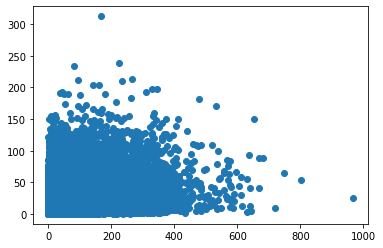

In [20]:
plt.scatter(abs_true_px, METx_list)

In [78]:
for x in METx_list:
    if x < 0:
        print(x)